In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pytz 
from scipy.optimize import minimize 
import generate_data
import economic_analysis
import optimization
from importlib import reload 



Things I should make classes:
PV Output profile
Battery output profile (has discharge and charge profile characteristics)

## Generate Data

### Simulate charging load and insolation profiles

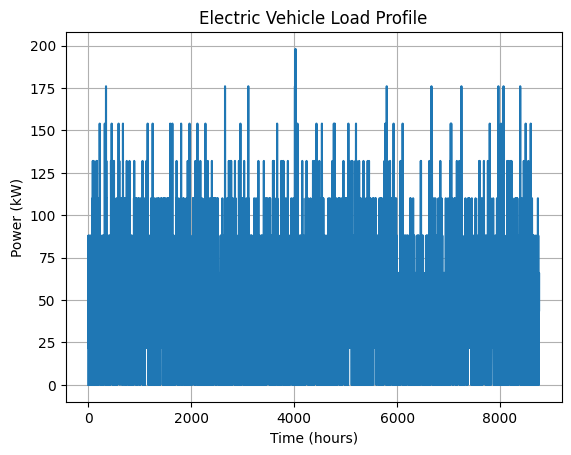

In [2]:
total_days = 365  # Total number of days to simulate
total_time = 24 * total_days  # Total simulation time in hours
time_resolution = 1  # Time resolution in hours (e.g., 0.25 means 15 minutes)
num_vehicles = 20  # Number of EVs in the simulation
charging_power = 22  # Charging power in kW (e.g., Level 2 charging)
load_profile = generate_data.simulate_charging_load_profile(total_days, total_time,time_resolution, num_vehicles, charging_power)

/Users/Orie4416/Desktop/Feasibility Assessment/chullenv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
/Users/Orie4416/Desktop/Feasibility Assessment/chullenv/lib/python3.9/site-packages/pysolar/radiation.py:50: RuntimeWarning: overflow encountered in exp
  return flux * math.exp(-1 * optical_depth * air_mass_ratio) * is_daytime
/Users/Orie4416/Desktop/Feasibility Assessment/chullenv/lib/python3.9/site-packages/pysolar/radiation.py:50: RuntimeWarning: invalid value encountered in scalar multiply
  return flux * math.exp(-1 * optical_depth * air_mass_ratio) * is_daytime


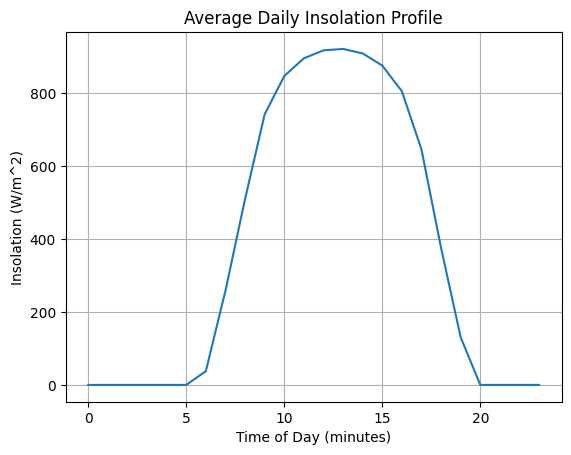

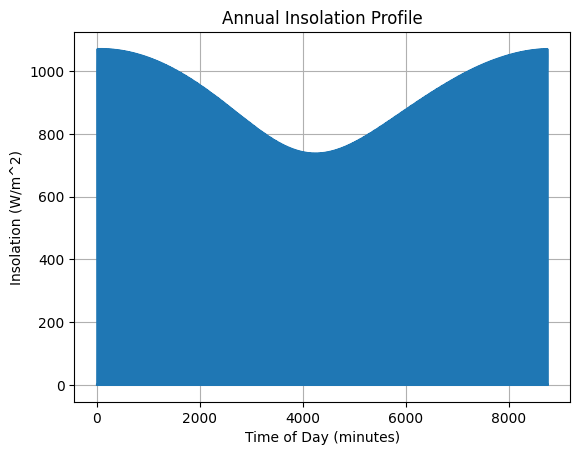

In [3]:
# Location coordinates (latitude, longitude)
latitude = -33.9321  # Stellenbosch, SA
longitude = 18.8602

# Time resolution in minutes
time_resolution = 60

# Set the time zone
timezone = pytz.timezone('Africa/Cairo')  
daily_insolation_profile, annual_insolation_profile = generate_data.simulate_insolation_profile(latitude, longitude, time_resolution, timezone)

### Define input parameters

In [42]:

# Financial market inputs
i_no = 0.0775 # interest rate
f = 0.071 # inflation rate
Rproj = 20 # project lifetime (yrs)
discount_rate = 0.05 # discount rate

# Energy market inputs
feed_in_tariff = 0.05 # $/kWh
flat_energy_usage_cost = 0.20 # $/kWh (unused parameter when using ToD)

# Taxi market inputs
cost_per_passenger = 1 # $/passenger

# Define time periods (in 10-minute increments since midnight)
morning_start = 5  # 5am
afternoon_start = 11  # 11am
evening_start = 16  # 4pm
night_start = 21  # 9pm
time_periods = {'morning_start': morning_start,
                'afternoon_start': afternoon_start,
                'evening_start': evening_start,
                'night_start': night_start}

# Energy costs for different time periods (e.g., morning, afternoon, evening, night)
morning_cost = 0.15  # $/kWh
afternoon_cost = 0.20  # $/kWh
evening_cost = 0.18  # $/kWh
night_cost = 0.12  # $/kWh
time_of_use_tariffs = {'morning': morning_cost,
                       'afternoon': afternoon_cost,
                       'evening': evening_cost,
                       'night': night_cost}

# Values of kWh in terms of passengers for different time periods 
time_passenger_per_kWh = {'morning': 0.66, 
                          'afternoon': 0.33,
                          'evening': 0.66, 
                          'night': 0.25}
# PV system specifications
pv_efficiency = 0.85  # 85% efficiency
pv_m_sq_per_kw = 6 
pv_cost_per_kw = 1000 # $/kW

# Inverter, mounting system, and installation costs
inverter_cost = 1000 # $
mounting_cost = 1000 # $
installation_cost = 1000 # $
additional_pv_capital_cost = inverter_cost + mounting_cost + installation_cost

# Environmental inputs
grid_carbon_intensity = 0.95 # kgCO2/kWh
carbon_price = 50/1000 # $/kgCo2


# Battery parameters
battery_cost_per_kWh = 400 # $/kWh
battery_charging_efficiency = 0.90
battery_discharging_efficiency = 0.90
battery_duration = 6 # hours 
 

# Station constraints
max_land_area = 1000 # m^2

# System specifications
loadshedding_probability = 3776 / 8760


# a = {
#     'annual_insolation_profile': annual_insolation_profile,
#     'pv_efficiency': pv_efficiency,
#     'load_profile': load_profile,
#     'flat_energy_usage_cost': flat_energy_usage_cost,
#     'Rproj': Rproj,
#     'pv_cost_per_kw': pv_cost_per_kw,
#     'i_no': i_no,
#     'f': f,
#     'discount_rate': discount_rate,
#     'time_of_use_tariffs': time_of_use_tariffs,
#     'time_periods': time_periods,
#     'feed_in_tariff': feed_in_tariff,
#     'battery_cost_per_kWh': battery_cost_per_kWh,
#     'feed_in_tariff_bool': False,
#     'loadshedding_probability': loadshedding_probability,
#     'time_passenger_per_kWh': time_passenger_per_kWh,
#     'cost_per_passenger': cost_per_passenger,
#     'grid_carbon_intensity': grid_carbon_intensity,
#     'carbon_price': carbon_price,
#     'additional_pv_capital_cost': additional_pv_capital_cost,
#     'pv_m_sq_per_kw': pv_m_sq_per_kw,
#     'max_land_area': max_land_area,
#     'max_battery_capacity': 20


# Financing parameters
loan_upfront_adjustment = 0.50 # 30% of capital cost paid upfront
loan_payback_period = 5 # 10 years for the solar PV system provider to fully recoup their costs

pays_capital_adjustment = 0.30 # 30% of capital cost paid upfront
pays_payback_period = 10 # 10 years for the solar PV system provider to fully recoup their costs
pays_annual_interest_rate = 0.05 # 5% annual interest rate
pays_cut_of_savings = 0.50 # 50% of savings go to the solar PV system provider




# }
a = {
    'annual_insolation_profile': annual_insolation_profile,
    'pv_efficiency': pv_efficiency,
    'load_profile': load_profile,
    'energy_usage_cost': flat_energy_usage_cost,
    'Rproj': Rproj,
    'pv_cost_per_kw': pv_cost_per_kw,
    'i_no': i_no,
    'f': f,
    'discount_rate': discount_rate,
    'time_of_use_tariffs': time_of_use_tariffs,
    'time_periods': time_periods,
    'feed_in_tariff': feed_in_tariff,
    'battery_cost_per_kWh': battery_cost_per_kWh,
    'feed_in_tariff_bool': False,
    'loadshedding_probability': loadshedding_probability,
    'time_passenger_per_kWh': time_passenger_per_kWh,
    'cost_per_passenger': cost_per_passenger,
    'grid_carbon_intensity': grid_carbon_intensity,
    'carbon_price': carbon_price,
    'additional_pv_capital_cost': additional_pv_capital_cost,
    'battery_charging_efficiency': battery_charging_efficiency,
    'battery_discharging_efficiency': battery_discharging_efficiency,
    'battery_duration': battery_duration,

}
a = {
    'annual_insolation_profile': annual_insolation_profile,
    'pv_efficiency': pv_efficiency,
    'load_profile': load_profile,
    'energy_usage_cost': flat_energy_usage_cost,
    'Rproj': Rproj,
    'pv_cost_per_kw': pv_cost_per_kw,
    'i_no': i_no,
    'f': f,
    'discount_rate': discount_rate,
    'time_of_use_tariffs': time_of_use_tariffs,
    'time_periods': time_periods,
    'feed_in_tariff': feed_in_tariff,
    'battery_cost_per_kWh': battery_cost_per_kWh,
    'feed_in_tariff_bool': False,
    'loadshedding_probability': loadshedding_probability,
    'time_passenger_per_kWh': time_passenger_per_kWh,
    'cost_per_passenger': cost_per_passenger,
    'grid_carbon_intensity': grid_carbon_intensity,
    'carbon_price': carbon_price,
    'additional_pv_capital_cost': additional_pv_capital_cost,
    'battery_charging_efficiency': battery_charging_efficiency,
    'battery_discharging_efficiency': battery_discharging_efficiency,
    'battery_duration': battery_duration,
    'penalty_weight': 1.5,
    # loan model
    'loan_upfront_adjustment': loan_upfront_adjustment,
    'loan_payback_period': loan_payback_period,
    # PAYS model
    'PAYS_capital_cost_adjustment': pays_capital_adjustment,
    'PAYS_payback_period': pays_payback_period,
    'PAYS_cut_of_savings': pays_cut_of_savings,
    # Cost of capital exponents
    'pv_cost_exponent': 1.5,
    'battery_cost_exponent': 1
}

## Optimization Model

### Base level optimization [this works don't touch it for now]

In [41]:
reload(generate_data)
reload(economic_analysis)

reload(optimization)
# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(1,100), (1,100)]

initial_guess = [20, 20]
##### CURRENT ISSUE IS WHEN I AM RUNNING OPTIMIZATION.PY VS THE DIRECT OPTIMIZATION IN FEASIBLITY ANALYSIS I GET DIFF ANSWERS 
### PROCESS TO FIX: REDUCE OBJECTIVE FUNCTION TO MOST BASIC FORM AND THEN BUILD UP TO SEE WHERE ERORR OCCURS
### ALSO THE MODULES DON'T SEEM TO BE IMOPRTING CORRECTLY (ESPECIALLY TO FEASIBLITY.IPYNB)

# Max land area constraint 
#constraint = {'type': 'ineq', 'fun': lambda x: a['max_land_area'] - (x[0] * a['pv_m_sq_per_kw'])} # ineq assumes >= 0

# Optimize
result = minimize(optimization.objective_function, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Maximum NPV : ${:.2f}".format(-max_npv))


Optimal PV rating: 39.48 kW
Optimal battery rating: 59.44 kWh
Maximum NPV : $160535.76


### Experimenting

Loadshedding penalty

In [43]:
reload(generate_data)
reload(economic_analysis)

reload(optimization)
# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(1,100), (1,100)]

initial_guess = [20, 20]
##### CURRENT ISSUE IS WHEN I AM RUNNING OPTIMIZATION.PY VS THE DIRECT OPTIMIZATION IN FEASIBLITY ANALYSIS I GET DIFF ANSWERS 
### PROCESS TO FIX: REDUCE OBJECTIVE FUNCTION TO MOST BASIC FORM AND THEN BUILD UP TO SEE WHERE ERORR OCCURS
### ALSO THE MODULES DON'T SEEM TO BE IMOPRTING CORRECTLY (ESPECIALLY TO FEASIBLITY.IPYNB)

# Max land area constraint 
#constraint = {'type': 'ineq', 'fun': lambda x: a['max_land_area'] - (x[0] * a['pv_m_sq_per_kw'])} # ineq assumes >= 0

# Avoid load shedding constraint - net load affected by loadshedding must equal 0
#constraint = {'type': 'eq', 'fun': lambda x: optimization.avoid_loadshedding(x,a)}


# Optimize
result = minimize(optimization.objective_function_with_loadshedding_penalty, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Maximum NPV : ${:.2f}".format(-max_npv))

# Constraint value
# constraint_value = constraint['fun'](result.x, a)
# print("Constraint value: {:.2f}".format(constraint_value))

KeyError: 'loan_upfront_adjustment'

### Playing with business models
1. Loan 
2. PAYS
3. PPA 
4. PPA / FIT


Loan

In [39]:
loan_upfront_adjustment = 0.50 # 30% of capital cost paid upfront
loan_payback_period = 5 # 10 years for the solar PV system provider to fully recoup their costs

pays_capital_adjustment = 0.30 # 30% of capital cost paid upfront
pays_payback_period = 10 # 10 years for the solar PV system provider to fully recoup their costs
pays_annual_interest_rate = 0.05 # 5% annual interest rate
pays_cut_of_savings = 0.50 # 50% of savings go to the solar PV system provider


reload(generate_data)
reload(economic_analysis)

reload(optimization)
# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(1,100), (1,100)]

initial_guess = [20, 20]


# Optimize
result = minimize(optimization.objective_function_for_loan, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Maximum NPV : ${:.2f}".format(-max_npv))

# Constraint value
# constraint_value = constraint['fun'](result.x, a)
# print("Constraint value: {:.2f}".format(constraint_value))

Optimal PV rating: 44.65 kW
Optimal battery rating: 100.00 kWh
Maximum NPV : $183361.73


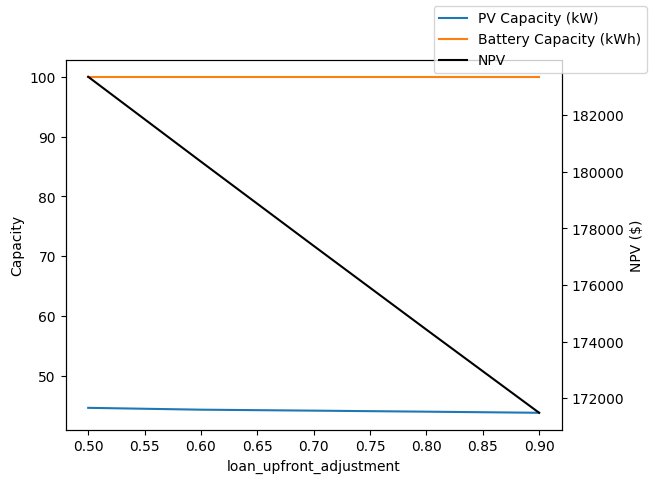

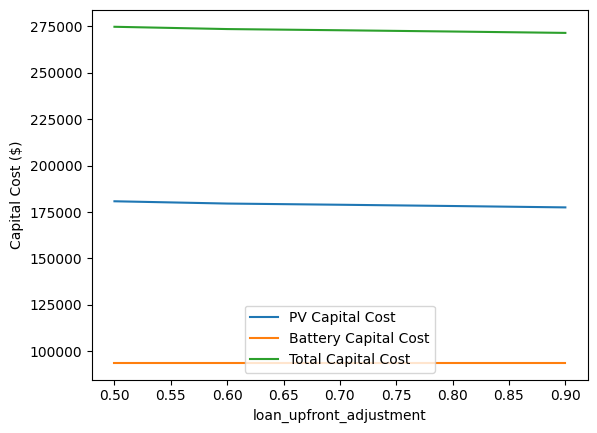

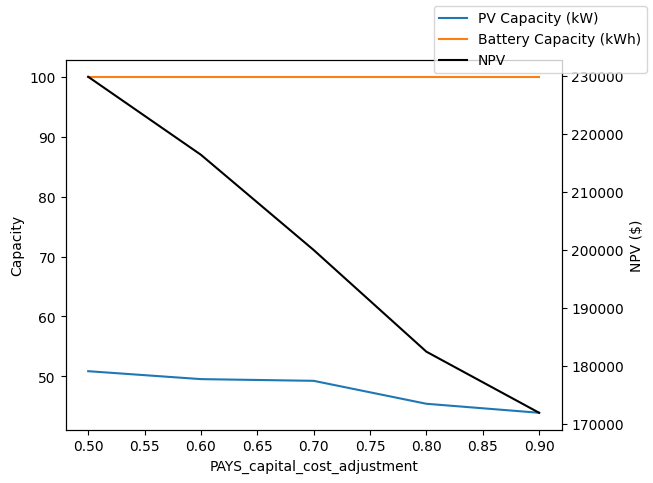

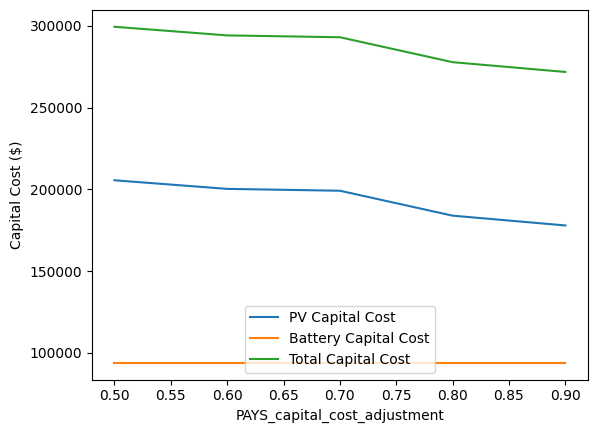

In [35]:
vals = [0.5, 0.6, 0.7, 0.8, 0.9]
reload(optimization)
a = {
    'annual_insolation_profile': annual_insolation_profile,
    'pv_efficiency': pv_efficiency,
    'load_profile': load_profile,
    'energy_usage_cost': flat_energy_usage_cost,
    'Rproj': Rproj,
    'pv_cost_per_kw': 1000,
    'i_no': i_no,
    'f': f,
    'discount_rate': discount_rate,
    'time_of_use_tariffs': time_of_use_tariffs,
    'time_periods': time_periods,
    'feed_in_tariff': feed_in_tariff,
    'battery_cost_per_kWh': 300,
    'feed_in_tariff_bool': False,
    'loadshedding_probability': loadshedding_probability,
    'time_passenger_per_kWh': time_passenger_per_kWh,
    'cost_per_passenger': cost_per_passenger,
    'grid_carbon_intensity': grid_carbon_intensity,
    'carbon_price': carbon_price,
    'additional_pv_capital_cost': additional_pv_capital_cost,
    'battery_charging_efficiency': battery_charging_efficiency,
    'battery_discharging_efficiency': battery_discharging_efficiency,
    'battery_duration': battery_duration,
    'penalty_weight': 1.5,
    # loan model
    'loan_upfront_adjustment': loan_upfront_adjustment,
    'loan_payback_period': loan_payback_period,
    # PAYS model
    'PAYS_capital_cost_adjustment': pays_capital_adjustment,
    'PAYS_payback_period': pays_payback_period,
    'PAYS_cut_of_savings': pays_cut_of_savings
}
b,c,d,e,f,g = optimization.plot_sensitivities('loan_upfront_adjustment', vals, bounds, initial_guess, a, optimization.objective_function_for_loan)
h,i,j,k,l,m = optimization.plot_sensitivities('PAYS_capital_cost_adjustment', vals, bounds, initial_guess, a, optimization.objective_function_PAYS)

In [32]:
print(b,c,d,e,f,g, '\n')
print(h,i,j,k,l,m)

[679799.0394061839, 678846.9074588245, 677895.4611703774, 676944.6538403267, 675994.4395069514] [1.6064020611936318, 1.5319852142886163, 1.4617877083086726, 1.396834281824126, 1.3339207318033655] [100.0, 100.0, 100.0, 100.0, 100.0] [135578.16069359944, 135578.16069359944, 135578.16069359944, 135578.16069359944, 135578.16069359944] [4892.853777524099, 4666.191499576021, 4452.380685581218, 4254.542531724579, 4062.9175280515888] [140471.01447112355, 140244.35219317547, 140030.54137918065, 139832.70322532402, 139641.07822165103] 

[681308.968091127, 678916.1530208205, 677100.9474557184, 675843.8143148059, 675148.2127830026] [2.346905284315227, 1.9151640118760371, 1.5388318693976588, 1.386250736622835, 1.3008556721684559] [99.99999999458126, 100.0, 99.9999999973172, 99.99999999540607, 99.99999999026079] [135578.1606864154, 135578.16069359944, 135578.16069004263, 135578.1606875089, 135578.16068068738] [7148.312781247662, 5833.295223191553, 4687.045358720593, 4222.306679711755, 3962.206438438

PAYS (I think this pretty much works? However it is yielding boundary condition battery. Think about why... Might need to play around with the input assumptions to get something)

In [7]:
reload(optimization)
reload(generate_data)
reload(economic_analysis)
pays_capital_adjustment = 0.80 # 30% of capital cost paid upfront
#pays_payback_period = 10 # 10 years for the solar PV system provider to fully recoup their costs
#pays_annual_interest_rate = 0.05 # 5% annual interest rate
pays_cut_of_savings = 0.50 # 50% of savings go to the solar PV system provider

a = {
    'annual_insolation_profile': annual_insolation_profile,
    'pv_efficiency': pv_efficiency,
    'load_profile': load_profile,
    'energy_usage_cost': flat_energy_usage_cost,
    'Rproj': Rproj,
    'pv_cost_per_kw': pv_cost_per_kw,
    'i_no': i_no,
    'f': f,
    'discount_rate': discount_rate,
    'time_of_use_tariffs': time_of_use_tariffs,
    'time_periods': time_periods,
    'feed_in_tariff': feed_in_tariff,
    'battery_cost_per_kWh': battery_cost_per_kWh,
    'feed_in_tariff_bool': False,
    'loadshedding_probability': loadshedding_probability,
    'time_passenger_per_kWh': time_passenger_per_kWh,
    'cost_per_passenger': cost_per_passenger,
    'grid_carbon_intensity': grid_carbon_intensity,
    'carbon_price': carbon_price,
    'additional_pv_capital_cost': additional_pv_capital_cost,
    'battery_charging_efficiency': battery_charging_efficiency,
    'battery_discharging_efficiency': battery_discharging_efficiency,
    'battery_duration': battery_duration,
    'penalty_weight': 1.5,
    # loan model
    'loan_upfront_adjustment': loan_upfront_adjustment,
    'loan_payback_period': loan_payback_period,
    # PAYS model
    'PAYS_capital_cost_adjustment': pays_capital_adjustment,
    'PAYS_cut_of_savings': pays_cut_of_savings
}

# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(1,100), (1,100)]

initial_guess = [20, 20]


# Optimize
result = minimize(optimization.objective_function_PAYS, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Maximum NPV : ${:.2f}".format(-max_npv))


Optimal PV rating: 41.75 kW
Optimal battery rating: 51.30 kWh
Maximum NPV : $167045.20


Check on values of other vars in optimal result

In [133]:
# Decision variables - PV capacity and Battery capacity 
pv_capacity = result.x[0]
battery_capacity = result.x[1]

# Capital Cost of Investment 
pv_capital_cost =  a['additional_pv_capital_cost'] + a['pv_cost_per_kw'] * pv_capacity ** 1.5   # (int) capital cost of PV system 
battery_capital_cost = a['battery_cost_per_kWh'] * battery_capacity  # (int) capital cost of battery
total_capital_cost = pv_capital_cost + battery_capital_cost

#### PAYS Business Model ####
upfront_payment = a['PAYS_capital_cost_adjustment'] * total_capital_cost # (int) upfront payment for panels
residual_cost_of_panels_owed = total_capital_cost - upfront_payment # (int) residual cost of panels owed

# Generate PV Output profile 
pv_output_profile = generate_data.get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], pv_capacity) 

# Generate load shedding schedule 
loadshedding_schedule = generate_data.generate_loadshedding_schedule(a['loadshedding_probability'])

# Generate PV output profile with battery
pv_with_battery_output_profile = generate_data.simulate_battery_storage(a['load_profile'], pv_output_profile, battery_capacity, a['battery_duration'],
                                                                        a['battery_charging_efficiency'], a['battery_discharging_efficiency'])
# Net charging load profile 
net_load_profile = a['load_profile'] - pv_with_battery_output_profile

# Profile of kWh that would be lost to load shedding WITHOUT  solar and battery 
gross_load_affected_by_loadshedding = np.array([a['load_profile'][i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)])

# Profile of kWh that would have been lost to loadshedding but are saved by the solar + battery generation [these are beneficial, and not to be charged $$ for]
saved_free_kWh = [min(pv_with_battery_output_profile[i], gross_load_affected_by_loadshedding[i]) if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)]

# Profile of kWh that would be lost to load shedding WITH solar and battery
net_load_affected_by_loadshedding = np.array([net_load_profile[i] if is_shedding and net_load_profile[i] > 0 else 0 for i, is_shedding in enumerate(loadshedding_schedule)])

# Find the load profiles that are net of load shedding - this is the load you neeed to charge $ for [in reality you will need an entirely new schedule] 
gross_load_minus_loadshedding = a['load_profile'] - gross_load_affected_by_loadshedding
net_load_minus_loadshedding = net_load_profile - net_load_affected_by_loadshedding 

# Value of kWh saved from loadshedding BY solar + battery!  [makes above not needed?]
value_of_charging_saved_by_pv_from_loadshedding = economic_analysis.get_cost_of_missed_passengers_from_loadshedding(saved_free_kWh, a['cost_per_passenger'],
                                                                                        a['time_passenger_per_kWh'], a['time_periods'])

# Energy costs ($ for kWh charged) (net of load shedding - so this is actually cheaper than without loadshedding, but we account for the value of missed trips elsewhere)
energy_cost_without_pv, energy_cost_with_pv = economic_analysis.get_cost_of_charging(gross_load_minus_loadshedding, net_load_minus_loadshedding,
                        a['time_of_use_tariffs'], a['time_periods'], a['feed_in_tariff'], feed_in_tariff_bool = a['feed_in_tariff_bool'])

##### Monetary savings (revenue) from solar + battery #######

# Carbon
carbon_savings_per_year = economic_analysis.get_value_of_carbon_offsets(gross_load_minus_loadshedding, net_load_minus_loadshedding, a['grid_carbon_intensity'], a['carbon_price'])

# Energy  
energy_savings_per_year = energy_cost_without_pv.sum() - energy_cost_with_pv.sum() # (float) revenue per year from energy savings 


# Operational
operational_savings_per_year = value_of_charging_saved_by_pv_from_loadshedding.sum() # (float) revenue per year from saved passengers

# Total 
#cash_flows = [energy_savings_per_year + operational_savings_per_year + carbon_savings_per_year for i in range(a['Rproj'])]

##### Calculate NPV #####
    # Payback
PAYS_payback_per_period = energy_savings_per_year * a['PAYS_cut_of_savings']

# Revenues TODO: In future versions these will need to be calculated separately for each period, for now assume constant in all periods
revenues = [energy_savings_per_year + operational_savings_per_year + carbon_savings_per_year for i in range(Rproj)]

# Costs
payback_per_period = max(PAYS_payback_per_period, residual_cost_of_panels_owed/Rproj)

num_periods = 0
paid_back = 0
while paid_back < residual_cost_of_panels_owed:
    paid_back += payback_per_period
    num_periods += 1 
    
costs = np.zeros(len(revenues))
# Fill the first num_periods elements of costs with PAYS_payback_per_period
costs[:num_periods] = payback_per_period
# Adjust the last filled element of cost so that the sum of costs is equal to residual_cost_of_panels_owed
costs[num_periods - 1] = costs[num_periods - 1] + (residual_cost_of_panels_owed - sum(costs[:num_periods]))

    
cash_flows = [revenue - cost for revenue,cost in zip(revenues,costs)]

values = []
for idx, cash_flow in enumerate(cash_flows):
    this_year_value = cash_flow /(1 + discount_rate)**idx
    values.append(this_year_value)
    
npv = sum(values) - upfront_payment

npv

166282.27191334864

In [89]:
not_covered_kWh = [net_load_profile[i] for i, is_shedding in enumerate(loadshedding_schedule) if is_shedding and net_load_profile[i] > 0]


2854

For input into chat GPT

### Todo:
0. Include feed in tariff in the ones with the battery?
0. <font color = 'orange'> Adjust the battery model to prioritize discharge during non-loadshedding hours (we can probably actually optimize the discharge profile since it is known - i.e. optimize it to minimize load shedding hours, or optimize it to minimize total expected cost (including the cost of loadshedding hours)) </font> - <font color = 'lightblue'> Meeting with Becky to discuss </font>
0. <font color = 'lightgreen'> Include capacity (kW) in the battery optimization (speed at which the battery can charge) </font>
2. Include power system gains (voltage stability, reliability?) evaluation, then include that in the objective function somehow... 
    1. include reliability in obj fun?
4. HEADLINE: Numbers or Model???
5. More considerations for optimziation model: Enhance resilience, reduce peak load, reduce loadshedding
    1. Penalty cost for buying during peak hours, penalty cost for resilience violations


1. <font color = 'red'> Options wiht loadshedding: 
    1. Simply evaluate the effect of loadshedding on operations (cost, etc.). Apply a generated loadshedding schedule (assign probability of loadshedding to each hour) to an EV load demand profile, and see how it would shift it if the EV charging operator was blind to the loadshedding before it happened (i.e. they only were able to repsond by charging when power is available).
    2. Optimize the battery storage around predicted loadshedding? 
    3. Use the EVs as storage devices as well (in tandem with the battery - could do this with Brendan)

If model, then I need to probably incldue some shit about loadshedding

IF numbers, then I need really really good dataset and the model needs to be highly accuraet